In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from sklearn.model_selection import train_test_split

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
encoded_label_dict = {"CG" : 0, "OR" : 1}
def encode_label(x):
    return encoded_label_dict.get(x,-1)

In [4]:
df = pd.read_csv("../../data/classification/data/deception_data.csv")

In [5]:
df["target"] = df["label"].apply(lambda x: encode_label(x))

In [6]:
model_name = "roberta-base"
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05

In [7]:
tokenizer = RobertaTokenizer.from_pretrained(model_name)

In [8]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.text_[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [9]:
# Creating the dataset and dataloader
test_dataset = df

print("VALID Dataset: {}".format(test_dataset.shape))

testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

VALID Dataset: (1600, 4)


In [10]:
test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
testing_loader = DataLoader(testing_set, **test_params)

#### Inference

In [11]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import torch

In [12]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

In [13]:
model = torch.load('../../data/classification/models/ft-roberta-amazonreviews.pt')

In [14]:
def predict(query, model, tokenizer, device="cuda"):
    tokens = tokenizer.encode(query)
    all_tokens = len(tokens)
    tokens = tokens[:tokenizer.model_max_length - 2]
    used_tokens = len(tokens)
    tokens = torch.tensor([tokenizer.bos_token_id] + tokens + [tokenizer.eos_token_id]).unsqueeze(0)
    mask = torch.ones_like(tokens)

    with torch.no_grad():
        logits = model(tokens.to(device), attention_mask=mask.to(device))[0]
        probs = logits.softmax(dim=-1)

    fake, real = probs.detach().cpu().flatten().numpy().tolist()
    return real

In [15]:
query = """I work in the wedding industry and have to work long days, on my feet, outside in the heat, and have to look professional. I've spent a ridiculous amount of money on high end dress shoes like Merrels and just have not been able to find a pair that are comfortable to wear all day. Both for my feet and my back. Enter the Sanuk yoga sling!!! These shoes are amazingly comfortable. Though, I will admit it took a few wears to get used to the feel of the yoga matte bottom. At first, it felt a little "sticky" to me, and the fabric part that goes through the toe area was a little thick and took some getting used to. I wore them for a few days before taking them out on a job and I can't get over how comfortable they are. Ii have been wearing these shoes now for 3 months, every work day and I am THRILLED. No more back pain, no more sore feet. I also wear these sometimes during my off time,mans every time I wear them, I get compliments on how cute and comfortable they look. The great thing about these shoes is the yoga matte bottom. It helps your feet grip to the shoe a bit, so your foot can just walk normally, without having to grip the shoe. You may not realize it, but with a lot of Sandals, your foot is having to work to keep the shoe on, changing the way you walk and stand and ultimately causing foot and back pain. Not with these! Also, the soft linen sits comfortably on your skin and breathes nicely in the heat. The only downside is the funky tan lines, which is why I am sure to alternate shoes on my days off, especially if I plan to be outside for most of the day. If it were not for that, I think these might be the only shoes I'd wear all summer. If you are looking for a reasonable priced, comfortable shoe that you can wear and walk in all day."""
predict(query,model,tokenizer)

0.9994001388549805

In [16]:
preds, preds_probas = [],[]
for i, row in test_dataset.iterrows():
    query = row["text_"]
    pred = predict(query,model,tokenizer)
    preds_probas.append(pred)
    if pred >= 0.5:
        preds.append(1)
    else:
        preds.append(0)

Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


In [17]:
from sklearn.metrics import confusion_matrix
y_true = test_dataset.target.values
y_pred = preds
confusion_matrix(y_true,y_pred)

array([[ 42, 758],
       [ 15, 785]])

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
acc = accuracy_score(y_true,y_pred)
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)

In [19]:
print(f"Accuracy: {acc*100}; Precision:{precision*100}; Recall:{recall*100}")

Accuracy: 51.6875; Precision:50.8749189889825; Recall:98.125


In [20]:
print(classification_report(y_true, y_pred, target_names=["CG","OR"]))

              precision    recall  f1-score   support

          CG       0.74      0.05      0.10       800
          OR       0.51      0.98      0.67       800

    accuracy                           0.52      1600
   macro avg       0.62      0.52      0.38      1600
weighted avg       0.62      0.52      0.38      1600



In [23]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr, tpr, thresh = roc_curve(y_true, preds_probas, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_true))]
p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)

In [24]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score = roc_auc_score(y_true, preds_probas)

print(auc_score)

0.6958562500000001


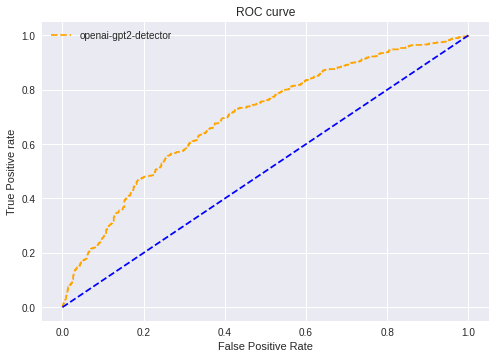

In [31]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='openai-gpt2-detector')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

In [38]:
import numpy as np
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), preds_probas)), key=lambda i: i[0], reverse=True)[0][1]
roc_predictions = np.array([1 if i >= optimal_proba_cutoff else 0 for i in preds_probas])

In [46]:
optimal_proba_cutoff

0.9995717406272888

In [48]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(y_true, y_pred), accuracy_score(y_true, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(y_true, y_pred), precision_score(y_true, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(y_true, y_pred), recall_score(y_true, roc_predictions)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(y_true, y_pred), f1_score(y_true, roc_predictions)))

Accuracy Score Before and After Thresholding: 0.5225, 0.64125
Precision Score Before and After Thresholding: 0.5118110236220472, 0.6632947976878613
Recall Score Before and After Thresholding: 0.975, 0.57375
F1 Score Before and After Thresholding: 0.6712564543889844, 0.6152815013404827


In [50]:
print("Classification Report After Thresholding\n")
print(classification_report(y_true, roc_predictions, target_names=["CG","OR"]))

Classification Report After Thresholding

              precision    recall  f1-score   support

          CG       0.62      0.71      0.66       800
          OR       0.66      0.57      0.62       800

    accuracy                           0.64      1600
   macro avg       0.64      0.64      0.64      1600
weighted avg       0.64      0.64      0.64      1600



#### Writing predictions to disc

In [21]:
preds_df_rows = []
for i, row in test_dataset.iterrows():
    query = row["text_"]
    pred_prob = preds_probas[i]
    pred_label = preds[i]
    preds_df_rows.append([pred_prob,pred_label])
preds_df = pd.DataFrame(preds_df_rows, columns=["Finetune_Roberta_Model_Probability","Finetune_Roberta_Model_Prediction"])

In [22]:
preds_df.to_csv("../../data/classification/data/ft_roberta_predictions_deception.csv", index=None)